In [155]:
import numpy as np                                     
import matplotlib.pyplot as plt                      
import seaborn as sns                                
from iminuit import Minuit                      
import sys             
from sympy import *                           
from scipy import stats
from scipy.stats import binom
from scipy.special import binom as binomcoef
from scipy.special import expit, gamma
from scipy.integrate import trapz, simpson
import scipy.interpolate as scint
import pandas as pd
import os
from importlib import reload

plt.style.use("../KD_style.mplstyle")

## Exercise 0

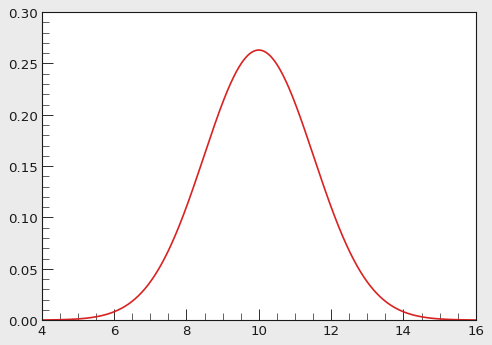

In [65]:
def gauss_pdf(x, mu, sigma):
    return stats.norm.pdf(x, mu, sigma)

mu_front = 10
sigma_front = np.sqrt(2.3)

x_front = np.arange(mu_front - 5 * sigma_front, mu_front + 5 * sigma_front, 0.01)
y_front = gauss_pdf(x_front, mu_front, sigma_front)
plt.plot(x_front, y_front)
xrange = (mu_front - 4 * sigma_front, mu_front + 4 * sigma_front)
plt.xlim(4, 16)
# plt.hlines(0, *xrange, color = "k", linewidth = 0.5)
plt.ylim(0, 0.3)
plt.grid(False)

## Exercise 1

In [192]:
def mc_ac_new(func, xmin, xmax, ymin, ymax, N_points, **kwargs):
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    yfunc = func(xran, **kwargs)
    bool_mask = yran <= yfunc
    missing = N_points - np.sum(bool_mask)
    if missing > 0:
        xrest, yrest, bool_rest = mc_ac_new(func, xmin, xmax, ymin, ymax, missing, **kwargs)
    else:
        xrest = np.empty(0)
        yrest = np.empty(0)
        bool_rest = np.empty(0, dtype = bool)
    finalx = np.append(xran, xrest)
    finaly = np.append(yran, yrest)
    finalbool = np.append(bool_mask, bool_rest)
    return finalx, finaly, finalbool

def mc_ac_df(func, xmin, xmax, ymin, ymax, N_points, upside_down = False, **kwargs):
    x, y, mask = mc_ac_new(func, xmin, xmax, ymin, ymax, N_points, **kwargs)
    if upside_down:
        mask = np.invert(mask)
    df = pd.DataFrame({"x": x, "y": y, "accept": mask})
    tries = len(x)
    eff = np.sum(mask)/tries
    area = (xmax - xmin) * (ymax - ymin) * eff
    return df, {"area": area, "effeciency": eff, "tries": tries}

def acceptreject_faster(func, xmin, xmax, ymin, ymax, N_points, **kwargs):
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    yfunc = func(xran, **kwargs)
    xkeep = xran[yran <= yfunc]
    ykeep = yran[yran <= yfunc]
    missing = N_points - len(xkeep)
    if missing > 0:
        xrest, yrest = acceptreject_faster(func, xmin, xmax, ymin, ymax, missing, **kwargs)
    else:
        xrest = np.empty(0)
        yrest = np.empty(0)
    finalx = np.append(xkeep, xrest)
    finaly = np.append(ykeep, yrest)
    return finalx, finaly

def acceptreject(func, xmin, xmax, ymin, ymax, N_points, **kwargs):
    # Recursive function to do accept/reject monte carlo simulation
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    yfunc = func(xran, **kwargs)
    xkeep = xran[yran <= yfunc]
    ykeep = yran[yran <= yfunc]
    missing = N_points - len(xkeep)
    if missing > 0:
        xrest, yrest, all_xrest, all_yrest, tries = acceptreject(func, xmin, xmax, ymin, ymax, missing, **kwargs)
    else:
        xrest = np.empty(0)
        yrest = np.empty(0)
        all_xrest = np.empty(0)
        all_yrest = np.empty(0)
        tries = 0
    finalx = np.append(xkeep, xrest)
    finaly = np.append(ykeep, yrest)
    allx = np.append(xran, all_xrest)
    ally = np.append(yran, all_yrest)
    finaltries = N_points + tries
    return finalx, finaly, allx, ally, finaltries

def acceptrejectdata(func, xmin, xmax, ymin, ymax, N_points, **kwargs):
    x, y, all_x, all_y, tries = acceptreject(func, xmin, xmax, ymin, ymax, N_points, **kwargs)
    eff = N_points/tries
    area = (xmax - xmin) * (ymax - ymin) * eff
    return x, y, all_x, all_y, (area, eff, tries)

def num_int2(func, xmin, xmax, points = 1000000, **kwargs):
    x = np.linspace(xmin, xmax, points)
    y = func(x, **kwargs)
    y_ave = y[1:] + (y[1:] - y[:-1])/2
    width = (xmax-xmin)/(points-1)
    area = np.sum(y_ave)*width
    return area

In [82]:
alpha = 0.9
beta = 0.55

xmin = -1.02
xmax = 1.11

def poly_pdf1(x, a, b):
    xmin = -1.02
    xmax = 1.11
    return (1+a*x+b*x**2)/((b*(-xmin**3+xmax**3)/3)+(a*(-xmin**2+xmax**2)/2)+(xmax-xmin))

xmin = -1.02
xmax = 1.11
ymin = 0
ymax = poly_pdf1(xmax, alpha, beta)

N_accept = 807

xquick = np.linspace(xmin, xmax, 10000)
yquick = poly_pdf1(xquick, alpha, beta)

poly_df, poly_info = mc_ac_df(poly_pdf1, xmin, xmax, ymin, ymax, N_accept, a = alpha, b = beta)
display(poly_df)
display(poly_df[["x", "y"]].loc[poly_df["accept"]])
# print(poly_df["x"])

,x,y,accept
0,-0.900313,0.143150,True
1,0.766610,0.482715,True
2,-0.513303,0.232222,True
3,0.758558,0.385935,True
4,0.016807,0.707153,False
...,...,...,...
1668,0.530835,0.589062,True
1669,-0.721393,0.387709,False
1670,0.782469,0.466778,True
1671,-0.508535,0.179636,True


,x,y
0,-0.900313,0.143150
1,0.766610,0.482715
2,-0.513303,0.232222
3,0.758558,0.385935
8,-0.816089,0.018630
...,...,...
1667,0.485460,0.268033
1668,0.530835,0.589062
1670,0.782469,0.466778
1671,-0.508535,0.179636


(0.0, 1.1)

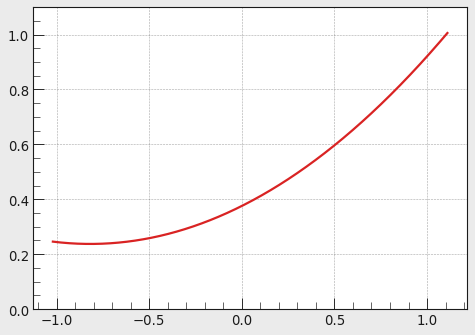

In [34]:
def num_int1(func, xmin, xmax, points = 100000, **kwargs):
    x = np.linspace(xmin, xmax, points)
    area = np.sum(func(x, **kwargs))/points*(xmax-xmin)
    return area

alpha = 0.9
beta = 0.55

xmin = -1.02
xmax = 1.11

def poly_pdf1(x, a, b):
    xmin = -1.02
    xmax = 1.11
    return (1+a*x+b*x**2)/((b*(-xmin**3+xmax**3)/3)+(a*(-xmin**2+xmax**2)/2)+(xmax-xmin))

xquick = np.linspace(xmin, xmax, 10000)
yquick = poly_pdf1(xquick, alpha, beta)
plt.plot(xquick, yquick)
plt.ylim(0,1.1)


(1.008555351422726, 0.470828471411902, 1714)


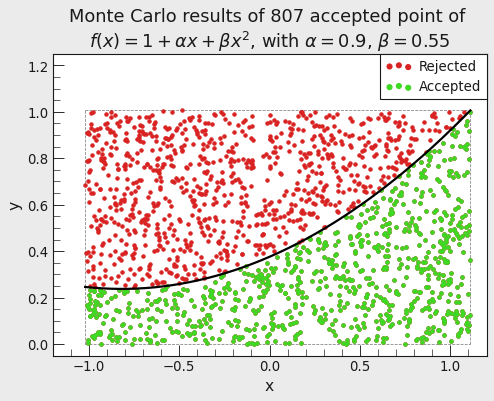

In [13]:
xmin = -1.02
xmax = 1.11
ymin = 0
ymax = poly_pdf1(xmax, alpha, beta)

N_accept = 807


xquick = np.linspace(xmin, xmax, 10000)
yquick = poly_pdf1(xquick, alpha, beta)
x, y, allx, ally, poly_MC_info = acceptrejectdata(poly_pdf1, xmin, xmax, ymin, ymax, N_accept, a = alpha, b = beta)

print(poly_MC_info)
plt.plot(xquick, yquick, color = "k")
plt.scatter(allx, ally, label = "Rejected")
plt.scatter(x,y, color = "#3dd923", label = "Accepted")
plt.grid(False)
plt.hlines(ymin, xmin, xmax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.hlines(ymax, xmin, xmax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.vlines(xmin, ymin, ymax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.vlines(xmax, ymin, ymax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.ylim(-0.05, 1.25)
plt.xlim(-1.2, 1.2)
plt.legend(scatterpoints = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Monte Carlo results of 807 accepted point of \n" + r"$f(x) = 1 + \alpha x + \beta x^{2}$, with $\alpha = 0.9$, $\beta = 0.55$")
plt.savefig("./montecarlo_poly_1.pdf", facecolor = "white")
plt.show()

# pd.DataFrame(np.array([x, y]).T, columns = ["x", "y"]).to_csv("./Kofoeddjursner_polynomial.txt" , index = None)

0.20458816554858644
(0.9952937783444746, 0.24324324324324326, 2109)


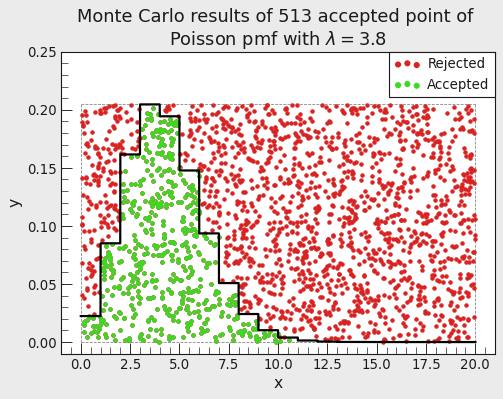

In [20]:
def poisson_pmf(x, lamb):
    return stats.poisson.pmf(np.floor(x), lamb)

xmin = 0
xmax = 20

lamb = 3.8

ymin = 0
ymax = poisson_pmf(lamb, lamb)
print(ymax)
N_accept = 513

xquick = np.linspace(xmin, xmax, 10000)
yquick = poisson_pmf(xquick, lamb)

x, y, allx, ally, poi_MC_info = acceptrejectdata(poisson_pmf, xmin, xmax, ymin, ymax, N_accept, lamb = lamb)
print(poi_MC_info)
plt.plot(xquick, yquick, color = "k")
plt.scatter(allx, ally, label = "Rejected")
plt.scatter(x,y, color = "#3dd923", label = "Accepted")
plt.grid(False)
plt.hlines(ymin, xmin, xmax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.hlines(ymax, xmin, xmax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.vlines(xmin, ymin, ymax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.vlines(xmax, ymin, ymax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.ylim(-0.01, 0.25)
# plt.xlim(-1.2, 1.2)
plt.legend(scatterpoints = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Monte Carlo results of 513 accepted point of \n" + r"Poisson pmf with $\lambda = 3.8$")
plt.savefig("./montecarlo_poisson_1.pdf", facecolor = "white")
plt.show()

# pd.DataFrame(np.array([x, y]).T, columns = ["x", "y"]).to_csv("./Kofoeddjursner_poisson.txt" , index = None)

In [21]:
sys.path.append('../Extra_External_Functions')
import EEF
reload(EEF)
from EEF import Datahandler

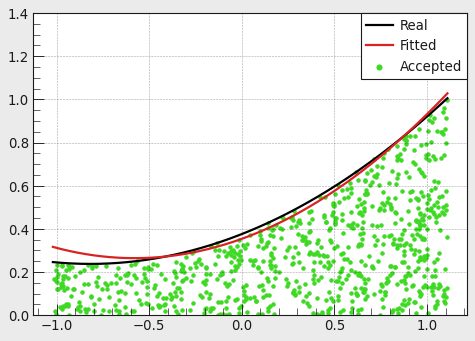

In [94]:
poly_x, poly_y = pd.read_csv("./Kofoeddjursner_polynomial.txt").values.T

def ullhfit(x, fitfunc, **kwargs):

    def obt(*args):
        logf = np.zeros_like(x)
        
        # compute the function value
        f = fitfunc(x, *args)
    
        # find where the PDF is 0 or negative (unphysical)        
        mask_f_positive = f > 0

        # calculate the log of f everyhere where f is positive
        logf[mask_f_positive] = np.log(f[mask_f_positive])
        # set everywhere else to badvalue
        logf[~mask_f_positive] = -1000000
        
        # compute the sum of the log values: the LLH
        llh = -np.sum(logf)
        return llh

    ullh_Min = Minuit(obt, **kwargs, name = [*kwargs])
    ullh_Min.errordef = 0.5
    ullh_Min.migrad()
    valuesfit = np.array(ullh_Min.values, dtype = np.float64)
    errorsfit = np.array(ullh_Min.errors, dtype = np.float64)
    if not ullh_Min.valid:
        print("!!! Fit did not converge !!!\n!!! Give better initial parameters !!!")
    # *** Impliment p-value for ullh fit
    
    return valuesfit, errorsfit

poly_fit, poly_errors = ullhfit(poly_x, poly_pdf1, a = alpha, b = beta)

xquick = np.linspace(xmin, xmax, 10000)
yquick = poly_pdf1(xquick, alpha, beta)
# x, y, allx, ally, poly_MC_info = acceptrejectdata(poly_pdf1, xmin, xmax, ymin, ymax, N_accept, a = alpha, b = beta)

# print(poly_MC_info)
plt.plot(xquick, yquick, color = "k", label = "Real")
# plt.scatter(allx, ally, label = "Rejected")
plt.scatter(poly_x, poly_y, color = "#3dd923", label = "Accepted")
plt.plot(xquick, poly_pdf1(xquick, *poly_fit), label = "Fitted")
plt.ylim(0, 1.4) 
plt.legend()

[3.84932517] [0.08661658]


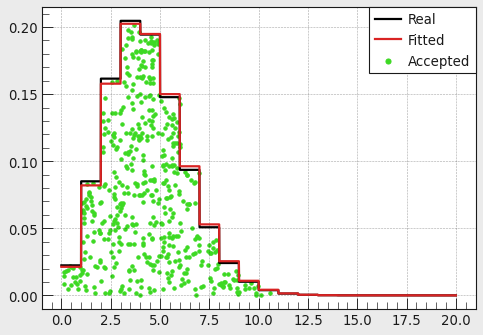

In [105]:
poi_x, poi_y = pd.read_csv("./Kofoeddjursner_poisson.txt").values.T

poi_fit, poi_errors = ullhfit(poi_x, poisson_pmf, lamb = 10)

xquick = np.linspace(0, 20, 10000)
yquick = poisson_pmf(xquick, lamb = lamb)
plt.plot(xquick, yquick, color = "k", label = "Real")
plt.scatter(poi_x, poi_y, color = "#3dd923", label = "Accepted")
plt.plot(xquick, poisson_pmf(xquick, *poi_fit), label = "Fitted")
print(poi_fit, poi_errors)
plt.legend()

## Problem 2

In [180]:
spline = pd.read_csv("./OutlineAreaSpline.txt", sep = " ", skiprows=1, names= ["x", "y"])
# display(spline)
lower = pd.concat([spline[:12],spline[37:]]).sort_values("x")
upper = spline[12:37].sort_values("x")

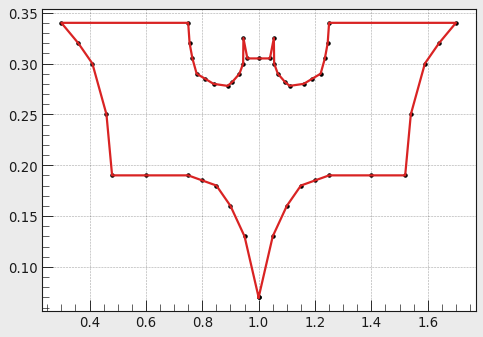

In [130]:
plt.scatter(spline["x"], spline["y"], color = "k")
plt.plot(spline["x"], spline["y"])

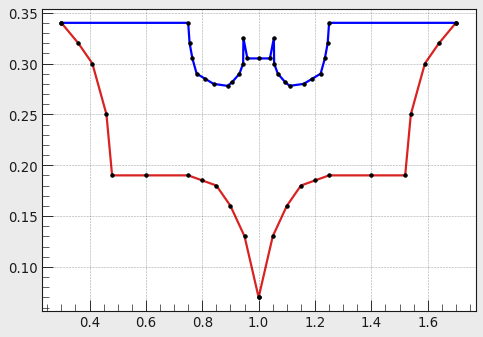

In [137]:
plt.plot(lower["x"], lower["y"], zorder = -10)
plt.scatter(lower["x"], lower["y"], color = "k")
plt.plot(upper["x"], upper["y"], color = "b", zorder = -10)
plt.scatter(upper["x"], upper["y"], color = "k")

In [149]:
lower_int_spline = scint.interp1d(lower["x"].values, lower["y"].values, kind = "linear")
upper_int_spline = scint.interp1d(upper["x"].values, upper["y"].values, kind = "linear")

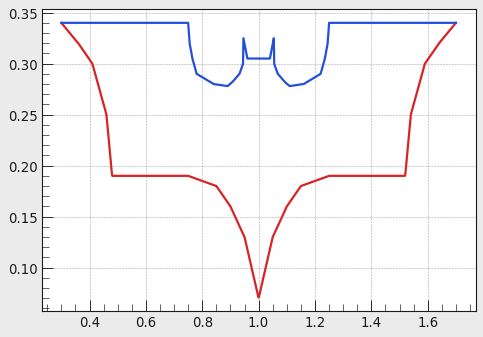

In [156]:
x_line_lower = np.linspace(np.min(lower["x"]), np.max(lower["x"]), 1000)
plt.plot(x_line_lower, lower_int_spline(x_line_lower))
plt.plot(x_line_lower, upper_int_spline(x_line_lower))

{'area': 0.18730760499432464, 'effeciency': 0.49552276453525035, 'tries': 198225}


<AxesSubplot:xlabel='x', ylabel='y'>

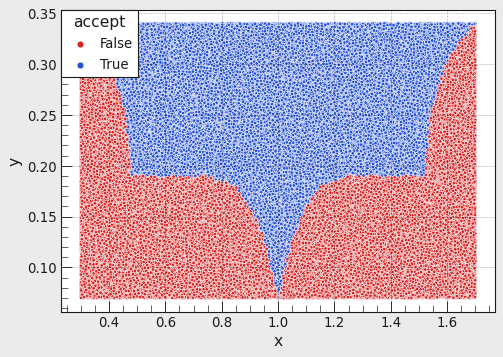

In [185]:
xmin = np.min(lower["x"])
xmax = np.max(lower["x"])
ymin = np.min(lower["y"])
ymax = np.max(lower["y"])
lower_ar, lower_info = mc_ac_df(lower_int_spline, xmin, xmax, ymin, ymax, 100000, upside_down=True)
print(lower_info)
sns.scatterplot(x = "x", y = "y", data = lower_ar, hue="accept")

{'area': 0.024124403930179433, 'effeciency': 0.7782065783928849, 'tries': 45087}


(0.05, 0.45)

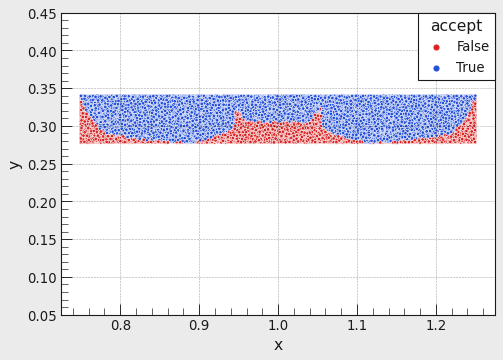

In [182]:
xmin = np.min(upper["x"])
xmax = np.max(upper["x"])
ymin = np.min(upper["y"])
ymax = np.max(upper["y"])
upper_ar, upper_info = mc_ac_df(upper_int_spline, xmin, xmax, ymin, ymax, 10000, upside_down=True)
print(upper_info)
sns.scatterplot(x = "x", y = "y", data = upper_ar, hue="accept")
plt.ylim(0.05, 0.45)

In [191]:
total_area = lower_info["area"]- upper_info["area"]
print(total_area) # area  = 0.1636 before redone code for plotting After 0.1632 with more points ()

0.16318320106414522


(0.0, 0.5)

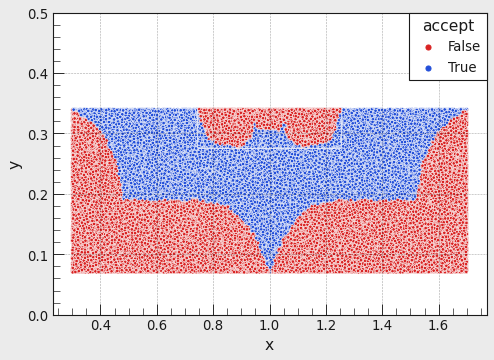

In [190]:
sns.scatterplot(x = "x", y = "y", data = lower_ar, hue="accept", legend=False)
upper_ar["accept"] = np.invert(upper_ar["accept"].values)
sns.scatterplot(x = "x", y = "y", data = upper_ar, hue="accept")
plt.ylim(0, 0.5)

In [162]:
print(np.invert([False, True]))

[ True False]
